In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = r"E:\TECO_Works\Conference\ISWC2022\Run_logs"              
args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
args.root_path        = r"E:\datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 150

args.learning_rate           = 0.001  
args.learning_rate_patience  = 5
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [3]:
args.seed                             = 1


args.data_name                        =  "hapt"

args.wavelet_filtering                = True
args.wavelet_filtering_regularization = True
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 6


args.difference       = False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler = False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## 模型参数

In [4]:
args.filter_scaling_factor = 0.5
args.model_type              = "deepconvlstm"#"deepconvlstm"#"sahar" #"deepconvlstm"

In [5]:
args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "gru"
args.temporal_info_aggregation_type = "FC"

In [6]:
# cross_channel_interaction_type = "attn",    # attn  transformer  identity
# cross_channel_aggregation_type = "filter",  # filter  naive  FC
# temporal_info_interaction_type = "gru",     # gru  lstm  attn  transformer  identity
# temporal_info_aggregation_type = "FC",      # naive  filter  FC 

# 实验

In [7]:
# 如果我们设置为 
args.wavelet_filtering_learnable      = False
exp = Exp(args)

Use GPU: cuda:0
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Done!
Parameter : 11996
Set the seed as :  1


In [8]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)

In [ ]:
exp.train()

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 30 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0006689  0.00068213 0.00073746 0.00061275 0.00056243 0.00056754
 0.00746269 0.01041667 0.00641026 0.00719424 0.00534759 0.00724638]
Train data number :  10339
The number of classes is :  12
The input_length  is :  128
The channel_in is :  6
Validation data number :  1149
Test data number :  6632
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Epoch: 1 cost time: 5.112706184387207
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.1243057  Vali Loss: 1.5590887 Vali Accur

Epoch: 27 cost time: 3.904878854751587
VALI: Epoch: 27, Steps: 41 | Train Loss: 0.1284937  Vali Loss: 0.1306750 Vali Accuracy: 0.9495213  Vali weighted F1: 0.9498041  Vali macro F1 0.7997825 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 28 cost time: 3.912872314453125
VALI: Epoch: 28, Steps: 41 | Train Loss: 0.1311302  Vali Loss: 0.1262835 Vali Accuracy: 0.9538729  Vali weighted F1: 0.9528438  Vali macro F1 0.8221715 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 29 cost time: 3.899869203567505
VALI: Epoch: 29, Steps: 41 | Train Loss: 0.1264658  Vali Loss: 0.1263690 Vali Accuracy: 0.9503916  Vali weighted F1: 0.9499618  Vali macro F1 0.8114484 
EarlyStopping counter: 4 out of 15
Learning rate adjusting counter: 4 out of 5
Epoch: 30 cost time: 3.897876501083374
VALI: Epoch: 30, Steps: 41 | Train Loss: 0.1157735  Vali Loss: 0.1226869 Vali Accuracy: 0.9521323  Vali weighted F1: 0.9506552  Vali macro F1 0.8078

[-] Target sampling weights:  [0.00064767 0.00068966 0.00072622 0.00061501 0.00056465 0.00055835
 0.00769231 0.01020408 0.00628931 0.00704225 0.00598802 0.00724638]
Train data number :  10393
The number of classes is :  12
The input_length  is :  128
The channel_in is :  6
Validation data number :  1155
Test data number :  6311
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Epoch: 1 cost time: 3.936885118484497
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.2153179  Vali Loss: 1.7547959 Vali Accuracy: 0.4112554  Vali weighted F1: 0.3098443  Vali macro F1 0.1706253 
Validation loss decreased (inf --> 1.754796).  Saving model ...
Epoch: 2 cost time: 3.90988826751709
VALI: Epoch: 2, Steps: 41 | Train Loss: 1.0921469  Vali Loss: 0.7776604 Vali Accuracy: 0.8190476  Vali weighted F1: 0.7837027  Vali macro F1 0.4264020 
new best score!!!!
Validation loss decreased (1.754796 --> 0.777660).  Saving model ...
ne

Epoch: 28 cost time: 3.9378867149353027
VALI: Epoch: 28, Steps: 41 | Train Loss: 0.1248254  Vali Loss: 0.1822502 Vali Accuracy: 0.9341991  Vali weighted F1: 0.9341872  Vali macro F1 0.7677877 
new best score!!!!
Validation loss decreased (0.183187 --> 0.182250).  Saving model ...
new best score!!!!
Epoch: 29 cost time: 4.053915977478027
VALI: Epoch: 29, Steps: 41 | Train Loss: 0.1185006  Vali Loss: 0.1712597 Vali Accuracy: 0.9376623  Vali weighted F1: 0.9378496  Vali macro F1 0.7878264 
new best score!!!!
Validation loss decreased (0.182250 --> 0.171260).  Saving model ...
new best score!!!!
Epoch: 30 cost time: 3.9418859481811523
VALI: Epoch: 30, Steps: 41 | Train Loss: 0.1167465  Vali Loss: 0.1818793 Vali Accuracy: 0.9402597  Vali weighted F1: 0.9395948  Vali macro F1 0.7857893 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 31 cost time: 3.9409048557281494
VALI: Epoch: 31, Steps: 41 | Train Loss: 0.1165019  Vali Loss: 0.1712453 Vali Accuracy: 0

VALI: Epoch: 57, Steps: 41 | Train Loss: 0.0750993  Vali Loss: 0.1502005 Vali Accuracy: 0.9471861  Vali weighted F1: 0.9476018  Vali macro F1 0.7974622 
EarlyStopping counter: 15 out of 15
Early stopping
Loading the best validation model!
Final Test Performance : Test Accuracy: 0.8771985  Test weighted F1: 0.8765818  Test macro F1 0.7357031 
================ the 2 th CV Experiment ================ 
Leave one Out Experiment : The 3 Part as the test
[-] Target sampling weights:  [0.00064061 0.00066934 0.0007215  0.00061728 0.00056148 0.00056593
 0.00724638 0.01       0.00662252 0.00704225 0.00540541 0.00714286]
Train data number :  10465
The number of classes is :  12
The input_length  is :  128
The channel_in is :  6
Validation data number :  1163
Test data number :  5897
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Epoch: 1 cost time: 4.00089955329895
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.23

Epoch: 27 cost time: 4.024915456771851
VALI: Epoch: 27, Steps: 41 | Train Loss: 0.1080940  Vali Loss: 0.1793948 Vali Accuracy: 0.9363715  Vali weighted F1: 0.9351388  Vali macro F1 0.7773496 
EarlyStopping counter: 4 out of 15
Learning rate adjusting counter: 4 out of 5
Epoch: 28 cost time: 3.9774281978607178
VALI: Epoch: 28, Steps: 41 | Train Loss: 0.0976604  Vali Loss: 0.1539854 Vali Accuracy: 0.9432502  Vali weighted F1: 0.9415945  Vali macro F1 0.7767361 
new best score!!!!
Validation loss decreased (0.157517 --> 0.153985).  Saving model ...
new best score!!!!
Epoch: 29 cost time: 3.9967517852783203
VALI: Epoch: 29, Steps: 41 | Train Loss: 0.0936184  Vali Loss: 0.1587620 Vali Accuracy: 0.9380911  Vali weighted F1: 0.9365414  Vali macro F1 0.7682509 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 30 cost time: 3.9814794063568115
VALI: Epoch: 30, Steps: 41 | Train Loss: 0.1003814  Vali Loss: 0.1551617 Vali Accuracy: 0.9423904  Vali weighted F1: 

Epoch: 2 cost time: 3.9191343784332275
VALI: Epoch: 2, Steps: 41 | Train Loss: 1.1314337  Vali Loss: 0.9417796 Vali Accuracy: 0.6157168  Vali weighted F1: 0.5289921  Vali macro F1 0.2874005 
new best score!!!!
Validation loss decreased (1.599318 --> 0.941780).  Saving model ...
new best score!!!!
Epoch: 3 cost time: 3.913872003555298
VALI: Epoch: 3, Steps: 41 | Train Loss: 0.7883941  Vali Loss: 0.7124481 Vali Accuracy: 0.6994819  Vali weighted F1: 0.6372251  Vali macro F1 0.3690365 
new best score!!!!
Validation loss decreased (0.941780 --> 0.712448).  Saving model ...
new best score!!!!
Epoch: 4 cost time: 3.9088892936706543
VALI: Epoch: 4, Steps: 41 | Train Loss: 0.5970404  Vali Loss: 0.5847817 Vali Accuracy: 0.8169257  Vali weighted F1: 0.8040124  Vali macro F1 0.4789191 
new best score!!!!
Validation loss decreased (0.712448 --> 0.584782).  Saving model ...
new best score!!!!
Epoch: 5 cost time: 3.9145445823669434
VALI: Epoch: 5, Steps: 41 | Train Loss: 0.4414456  Vali Loss: 0.4156

Epoch: 31 cost time: 3.921882390975952
VALI: Epoch: 31, Steps: 41 | Train Loss: 0.1291623  Vali Loss: 0.1997519 Vali Accuracy: 0.9283247  Vali weighted F1: 0.9280401  Vali macro F1 0.7532135 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 32 cost time: 3.9248828887939453
VALI: Epoch: 32, Steps: 41 | Train Loss: 0.1223218  Vali Loss: 0.2028644 Vali Accuracy: 0.9335060  Vali weighted F1: 0.9338233  Vali macro F1 0.7599082 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 33 cost time: 3.9278757572174072
VALI: Epoch: 33, Steps: 41 | Train Loss: 0.1216871  Vali Loss: 0.1991479 Vali Accuracy: 0.9326425  Vali weighted F1: 0.9324785  Vali macro F1 0.7584426 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 34 cost time: 3.9401752948760986
VALI: Epoch: 34, Steps: 41 | Train Loss: 0.1148420  Vali Loss: 0.1899004 Vali Accuracy: 0.9335060  Vali weighted F1: 0.9341992  Vali macro F1 0.7

Epoch: 7 cost time: 3.9295923709869385
VALI: Epoch: 7, Steps: 41 | Train Loss: 0.3313774  Vali Loss: 0.3372325 Vali Accuracy: 0.8740226  Vali weighted F1: 0.8605634  Vali macro F1 0.5052822 
new best score!!!!
Validation loss decreased (0.393905 --> 0.337233).  Saving model ...
new best score!!!!
Epoch: 8 cost time: 3.9628918170928955
VALI: Epoch: 8, Steps: 41 | Train Loss: 0.3098520  Vali Loss: 0.3153918 Vali Accuracy: 0.8792354  Vali weighted F1: 0.8684829  Vali macro F1 0.5144145 
new best score!!!!
Validation loss decreased (0.337233 --> 0.315392).  Saving model ...
new best score!!!!
Epoch: 9 cost time: 3.9338767528533936
VALI: Epoch: 9, Steps: 41 | Train Loss: 0.2914291  Vali Loss: 0.3242698 Vali Accuracy: 0.8714162  Vali weighted F1: 0.8637510  Vali macro F1 0.5282355 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 10 cost time: 3.89286732673645
VALI: Epoch: 10, Steps: 41 | Train Loss: 0.2863423  Vali Loss: 0.3053899 Vali Accuracy: 0.880104

Epoch: 36 cost time: 3.9258532524108887
VALI: Epoch: 36, Steps: 41 | Train Loss: 0.1048641  Vali Loss: 0.1399220 Vali Accuracy: 0.9435274  Vali weighted F1: 0.9434411  Vali macro F1 0.7953476 
new best score!!!!
Validation loss decreased (0.141294 --> 0.139922).  Saving model ...
new best score!!!!
Epoch: 37 cost time: 4.002892732620239
VALI: Epoch: 37, Steps: 41 | Train Loss: 0.1004961  Vali Loss: 0.1622149 Vali Accuracy: 0.9331017  Vali weighted F1: 0.9316159  Vali macro F1 0.7892597 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 38 cost time: 4.045907735824585
VALI: Epoch: 38, Steps: 41 | Train Loss: 0.0994343  Vali Loss: 0.1518736 Vali Accuracy: 0.9400521  Vali weighted F1: 0.9388011  Vali macro F1 0.7938030 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 39 cost time: 4.020905256271362
VALI: Epoch: 39, Steps: 41 | Train Loss: 0.0986233  Vali Loss: 0.1420851 Vali Accuracy: 0.9452650  Vali weighted F1: 0.

Epoch: 5 cost time: 3.849858283996582
VALI: Epoch: 5, Steps: 40 | Train Loss: 0.6023501  Vali Loss: 0.5305093 Vali Accuracy: 0.7768014  Vali weighted F1: 0.7426182  Vali macro F1 0.4237059 
new best score!!!!
Validation loss decreased (0.642530 --> 0.530509).  Saving model ...
new best score!!!!
Epoch: 6 cost time: 3.9198830127716064
VALI: Epoch: 6, Steps: 40 | Train Loss: 0.5186896  Vali Loss: 0.4823337 Vali Accuracy: 0.7978910  Vali weighted F1: 0.7861164  Vali macro F1 0.4948061 
new best score!!!!
Validation loss decreased (0.530509 --> 0.482334).  Saving model ...
new best score!!!!
Epoch: 7 cost time: 3.922882318496704
VALI: Epoch: 7, Steps: 40 | Train Loss: 0.4726010  Vali Loss: 0.4481431 Vali Accuracy: 0.8110721  Vali weighted F1: 0.7891070  Vali macro F1 0.5387503 
new best score!!!!
Validation loss decreased (0.482334 --> 0.448143).  Saving model ...
new best score!!!!
Epoch: 8 cost time: 3.898878574371338
VALI: Epoch: 8, Steps: 40 | Train Loss: 0.4213179  Vali Loss: 0.380416

Epoch: 34 cost time: 3.9948344230651855
VALI: Epoch: 34, Steps: 40 | Train Loss: 0.1051135  Vali Loss: 0.1600018 Vali Accuracy: 0.9376098  Vali weighted F1: 0.9374485  Vali macro F1 0.7633472 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 35 cost time: 3.8948867321014404
VALI: Epoch: 35, Steps: 40 | Train Loss: 0.1051689  Vali Loss: 0.1598420 Vali Accuracy: 0.9393673  Vali weighted F1: 0.9396933  Vali macro F1 0.7786689 
EarlyStopping counter: 4 out of 15
Learning rate adjusting counter: 4 out of 5
Epoch: 36 cost time: 3.9008796215057373
VALI: Epoch: 36, Steps: 40 | Train Loss: 0.1062205  Vali Loss: 0.1596178 Vali Accuracy: 0.9367311  Vali weighted F1: 0.9367636  Vali macro F1 0.7631142 
EarlyStopping counter: 5 out of 15
Learning rate adjusting counter: 5 out of 5
Updating learning rate to 1e-05
Epoch: 37 cost time: 3.8998782634735107
VALI: Epoch: 37, Steps: 40 | Train Loss: 0.1015779  Vali Loss: 0.1597647 Vali Accuracy: 0.9393673  Vali weighted

Epoch: 15 cost time: 3.880873441696167
VALI: Epoch: 15, Steps: 40 | Train Loss: 0.1866245  Vali Loss: 0.1990320 Vali Accuracy: 0.9190141  Vali weighted F1: 0.9159503  Vali macro F1 0.6981369 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 16 cost time: 3.8978686332702637
VALI: Epoch: 16, Steps: 40 | Train Loss: 0.1886235  Vali Loss: 0.1774817 Vali Accuracy: 0.9234155  Vali weighted F1: 0.9183734  Vali macro F1 0.6578889 
new best score!!!!
Validation loss decreased (0.191577 --> 0.177482).  Saving model ...
new best score!!!!
Epoch: 17 cost time: 3.905198812484741
VALI: Epoch: 17, Steps: 40 | Train Loss: 0.1736808  Vali Loss: 0.1882542 Vali Accuracy: 0.9269366  Vali weighted F1: 0.9243879  Vali macro F1 0.7116134 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 18 cost time: 3.886874198913574
VALI: Epoch: 18, Steps: 40 | Train Loss: 0.1708352  Vali Loss: 0.1641399 Vali Accuracy: 0.9330986  Vali weighted F1: 0.

VALI: Epoch: 44, Steps: 40 | Train Loss: 0.0763261  Vali Loss: 0.1281323 Vali Accuracy: 0.9533451  Vali weighted F1: 0.9521441  Vali macro F1 0.8195059 
EarlyStopping counter: 12 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 45 cost time: 3.853858709335327
VALI: Epoch: 45, Steps: 40 | Train Loss: 0.0792706  Vali Loss: 0.1302194 Vali Accuracy: 0.9533451  Vali weighted F1: 0.9521441  Vali macro F1 0.8195059 
EarlyStopping counter: 13 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 46 cost time: 3.876863718032837
VALI: Epoch: 46, Steps: 40 | Train Loss: 0.0802710  Vali Loss: 0.1290125 Vali Accuracy: 0.9533451  Vali weighted F1: 0.9521441  Vali macro F1 0.8195059 
EarlyStopping counter: 14 out of 15
Learning rate adjusting counter: 4 out of 5
Epoch: 47 cost time: 3.9708921909332275
VALI: Epoch: 47, Steps: 40 | Train Loss: 0.0762875  Vali Loss: 0.1286611 Vali Accuracy: 0.9533451  Vali weighted F1: 0.9521441  Vali macro F1 0.8195059 
EarlyStopping counter: 15 out 

Epoch: 24 cost time: 3.948896646499634
VALI: Epoch: 24, Steps: 41 | Train Loss: 0.1428887  Vali Loss: 0.1867928 Vali Accuracy: 0.9299475  Vali weighted F1: 0.9285988  Vali macro F1 0.7626380 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 25 cost time: 3.9299089908599854
VALI: Epoch: 25, Steps: 41 | Train Loss: 0.1714094  Vali Loss: 0.2208600 Vali Accuracy: 0.9141856  Vali weighted F1: 0.9115512  Vali macro F1 0.7386127 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 26 cost time: 3.928621530532837
VALI: Epoch: 26, Steps: 41 | Train Loss: 0.1454994  Vali Loss: 0.1696788 Vali Accuracy: 0.9395797  Vali weighted F1: 0.9375791  Vali macro F1 0.7669171 
new best score!!!!
Validation loss decreased (0.177684 --> 0.169679).  Saving model ...
new best score!!!!
Epoch: 27 cost time: 3.9198737144470215
VALI: Epoch: 27, Steps: 41 | Train Loss: 0.1361217  Vali Loss: 0.1810494 Vali Accuracy: 0.9273205  Vali weighted F1: 0

Epoch: 3 cost time: 3.8328542709350586
VALI: Epoch: 3, Steps: 40 | Train Loss: 0.8658931  Vali Loss: 0.6968413 Vali Accuracy: 0.7199647  Vali weighted F1: 0.6992251  Vali macro F1 0.4666476 
new best score!!!!
Validation loss decreased (1.015299 --> 0.696841).  Saving model ...
new best score!!!!
Epoch: 4 cost time: 3.831862688064575
VALI: Epoch: 4, Steps: 40 | Train Loss: 0.6164120  Vali Loss: 0.5425132 Vali Accuracy: 0.7773852  Vali weighted F1: 0.7639215  Vali macro F1 0.5183319 
new best score!!!!
Validation loss decreased (0.696841 --> 0.542513).  Saving model ...
new best score!!!!
Epoch: 5 cost time: 3.879863977432251
VALI: Epoch: 5, Steps: 40 | Train Loss: 0.5013470  Vali Loss: 0.4217881 Vali Accuracy: 0.8780919  Vali weighted F1: 0.8733148  Vali macro F1 0.5817842 
new best score!!!!
Validation loss decreased (0.542513 --> 0.421788).  Saving model ...
new best score!!!!
Epoch: 6 cost time: 3.837855577468872
VALI: Epoch: 6, Steps: 40 | Train Loss: 0.3702980  Vali Loss: 0.349674

Epoch: 32 cost time: 3.8338544368743896
VALI: Epoch: 32, Steps: 40 | Train Loss: 0.1037462  Vali Loss: 0.2147759 Vali Accuracy: 0.9231449  Vali weighted F1: 0.9244488  Vali macro F1 0.7742460 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 33 cost time: 3.84686541557312
VALI: Epoch: 33, Steps: 40 | Train Loss: 0.1051592  Vali Loss: 0.1583561 Vali Accuracy: 0.9469965  Vali weighted F1: 0.9476180  Vali macro F1 0.8135053 
new best score!!!!
Validation loss decreased (0.163029 --> 0.158356).  Saving model ...
new best score!!!!
Epoch: 34 cost time: 3.8728721141815186
VALI: Epoch: 34, Steps: 40 | Train Loss: 0.0962948  Vali Loss: 0.1744542 Vali Accuracy: 0.9443463  Vali weighted F1: 0.9449425  Vali macro F1 0.8204040 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 35 cost time: 3.9588828086853027
VALI: Epoch: 35, Steps: 40 | Train Loss: 0.1026585  Vali Loss: 0.1693710 Vali Accuracy: 0.9469965  Vali weighted F1: 0

Epoch: 5 cost time: 3.928623676300049
VALI: Epoch: 5, Steps: 41 | Train Loss: 0.3251824  Vali Loss: 0.3415517 Vali Accuracy: 0.8885965  Vali weighted F1: 0.8744379  Vali macro F1 0.5641228 
new best score!!!!
Validation loss decreased (0.383276 --> 0.341552).  Saving model ...
new best score!!!!
Epoch: 6 cost time: 3.900876998901367
VALI: Epoch: 6, Steps: 41 | Train Loss: 0.2998263  Vali Loss: 0.3197368 Vali Accuracy: 0.8859649  Vali weighted F1: 0.8779745  Vali macro F1 0.5614064 
new best score!!!!
Validation loss decreased (0.341552 --> 0.319737).  Saving model ...
new best score!!!!
Epoch: 7 cost time: 3.885874032974243
VALI: Epoch: 7, Steps: 41 | Train Loss: 0.2894620  Vali Loss: 0.3107676 Vali Accuracy: 0.8833333  Vali weighted F1: 0.8737424  Vali macro F1 0.5736304 
new best score!!!!
Validation loss decreased (0.319737 --> 0.310768).  Saving model ...
new best score!!!!
Epoch: 8 cost time: 3.892876386642456
VALI: Epoch: 8, Steps: 41 | Train Loss: 0.2518516  Vali Loss: 0.2677006

Epoch: 34 cost time: 3.9118714332580566
VALI: Epoch: 34, Steps: 41 | Train Loss: 0.1560752  Vali Loss: 0.1632832 Vali Accuracy: 0.9394737  Vali weighted F1: 0.9376113  Vali macro F1 0.8029159 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 35 cost time: 3.919881820678711
VALI: Epoch: 35, Steps: 41 | Train Loss: 0.1493215  Vali Loss: 0.1575880 Vali Accuracy: 0.9403509  Vali weighted F1: 0.9392826  Vali macro F1 0.7940322 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 36 cost time: 3.903870105743408
VALI: Epoch: 36, Steps: 41 | Train Loss: 0.1183654  Vali Loss: 0.1455490 Vali Accuracy: 0.9464912  Vali weighted F1: 0.9448522  Vali macro F1 0.8084145 
new best score!!!!
Validation loss decreased (0.148027 --> 0.145549).  Saving model ...
new best score!!!!
Epoch: 37 cost time: 3.90114164352417
VALI: Epoch: 37, Steps: 41 | Train Loss: 0.1152576  Vali Loss: 0.1384848 Vali Accuracy: 0.9491228  Vali weighted F1: 0.9

Epoch: 64 cost time: 3.904885768890381
VALI: Epoch: 64, Steps: 41 | Train Loss: 0.0819535  Vali Loss: 0.1307099 Vali Accuracy: 0.9508772  Vali weighted F1: 0.9505155  Vali macro F1 0.8188535 
EarlyStopping counter: 6 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 65 cost time: 3.897876501083374
VALI: Epoch: 65, Steps: 41 | Train Loss: 0.0808308  Vali Loss: 0.1350369 Vali Accuracy: 0.9491228  Vali weighted F1: 0.9487739  Vali macro F1 0.8106833 
EarlyStopping counter: 7 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 66 cost time: 3.899869203567505
VALI: Epoch: 66, Steps: 41 | Train Loss: 0.0800532  Vali Loss: 0.1333835 Vali Accuracy: 0.9482456  Vali weighted F1: 0.9480859  Vali macro F1 0.8093548 
EarlyStopping counter: 8 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 67 cost time: 3.8968758583068848
VALI: Epoch: 67, Steps: 41 | Train Loss: 0.0793440  Vali Loss: 0.1342367 Vali Accuracy: 0.9473684  Vali weighted F1: 0.9469448  Vali macro F1 0.802

Epoch: 18 cost time: 4.249955654144287
VALI: Epoch: 18, Steps: 44 | Train Loss: 0.1584541  Vali Loss: 0.2037201 Vali Accuracy: 0.9271255  Vali weighted F1: 0.9246493  Vali macro F1 0.6807239 
new best score!!!!
Validation loss decreased (0.211896 --> 0.203720).  Saving model ...
new best score!!!!
Epoch: 19 cost time: 4.214953184127808
VALI: Epoch: 19, Steps: 44 | Train Loss: 0.1574109  Vali Loss: 0.2103478 Vali Accuracy: 0.9263158  Vali weighted F1: 0.9213905  Vali macro F1 0.7073168 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 20 cost time: 4.200952529907227
VALI: Epoch: 20, Steps: 44 | Train Loss: 0.1536502  Vali Loss: 0.2075388 Vali Accuracy: 0.9246964  Vali weighted F1: 0.9211081  Vali macro F1 0.7036747 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 21 cost time: 4.206946134567261
VALI: Epoch: 21, Steps: 44 | Train Loss: 0.1449047  Vali Loss: 0.1903755 Vali Accuracy: 0.9255061  Vali weighted F1: 0.9

Epoch: 48 cost time: 4.255956649780273
VALI: Epoch: 48, Steps: 44 | Train Loss: 0.0792572  Vali Loss: 0.1559649 Vali Accuracy: 0.9441296  Vali weighted F1: 0.9418390  Vali macro F1 0.7755983 
EarlyStopping counter: 5 out of 15
Learning rate adjusting counter: 5 out of 5
Updating learning rate to 1e-05
Epoch: 49 cost time: 4.3949806690216064
VALI: Epoch: 49, Steps: 44 | Train Loss: 0.0774729  Vali Loss: 0.1570875 Vali Accuracy: 0.9433198  Vali weighted F1: 0.9407008  Vali macro F1 0.7624499 
EarlyStopping counter: 6 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 50 cost time: 4.243946552276611


 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 30 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0006689  0.00068213 0.00073746 0.00061275 0.00056243 0.00056754
 0.00746269 0.01041667 0.00641026 0.00719424 0.00534759 0.00724638]
Train data number :  10339
The number of classes is :  12
The input_length  is :  128
The channel_in is :  6
Validation data number :  1149
Test data number :  6632
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Epoch: 1 cost time: 5.1612396240234375
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.2669251  Vali Loss: 2.1454006 Vali Accu

Epoch: 27 cost time: 3.996898889541626
VALI: Epoch: 27, Steps: 41 | Train Loss: 0.2635574  Vali Loss: 0.2989033 Vali Accuracy: 0.8764143  Vali weighted F1: 0.8718600  Vali macro F1 0.6532226 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 28 cost time: 3.9918899536132812
VALI: Epoch: 28, Steps: 41 | Train Loss: 0.2640532  Vali Loss: 0.2737101 Vali Accuracy: 0.8868581  Vali weighted F1: 0.8827080  Vali macro F1 0.6251559 
new best score!!!!
Validation loss decreased (0.286004 --> 0.273710).  Saving model ...
new best score!!!!
Epoch: 29 cost time: 3.972893714904785
VALI: Epoch: 29, Steps: 41 | Train Loss: 0.2555665  Vali Loss: 0.2994884 Vali Accuracy: 0.8868581  Vali weighted F1: 0.8854481  Vali macro F1 0.6656535 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 30 cost time: 3.9888975620269775
VALI: Epoch: 30, Steps: 41 | Train Loss: 0.2531698  Vali Loss: 0.2809928 Vali Accuracy: 0.8903394  Vali weighted F1: 0

Epoch: 1 cost time: 4.004335880279541
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.2659063  Vali Loss: 2.0690308 Vali Accuracy: 0.3549784  Vali weighted F1: 0.2297810  Vali macro F1 0.1345096 
Validation loss decreased (inf --> 2.069031).  Saving model ...
Epoch: 2 cost time: 4.006162643432617
VALI: Epoch: 2, Steps: 41 | Train Loss: 1.5172742  Vali Loss: 1.1548715 Vali Accuracy: 0.5792208  Vali weighted F1: 0.5058045  Vali macro F1 0.2787221 
new best score!!!!
Validation loss decreased (2.069031 --> 1.154871).  Saving model ...
new best score!!!!
Epoch: 3 cost time: 3.98698091506958
VALI: Epoch: 3, Steps: 41 | Train Loss: 0.8434642  Vali Loss: 0.6692187 Vali Accuracy: 0.7679654  Vali weighted F1: 0.7440618  Vali macro F1 0.4505360 
new best score!!!!
Validation loss decreased (1.154871 --> 0.669219).  Saving model ...
new best score!!!!
Epoch: 4 cost time: 3.971363067626953
VALI: Epoch: 4, Steps: 41 | Train Loss: 0.5590366  Vali Loss: 0.5324737 Vali Accuracy: 0.8207792  Vali weighted F1:

KeyboardInterrupt: 

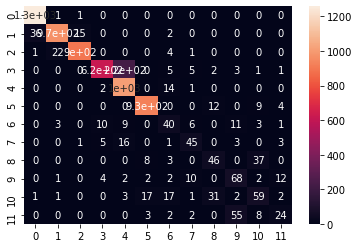

In [9]:
exp.train()

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 30 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0006689  0.00068213 0.00073746 0.00061275 0.00056243 0.00056754
 0.00746269 0.01041667 0.00641026 0.00719424 0.00534759 0.00724638]
Train data number :  10339
The number of classes is :  12
The input_length  is :  128
The channel_in is :  6
Validation data number :  1149
Test data number :  6632
================ Build the model ================ 
clone the  wavefiler weight
Wavelet Filtering Regularization
Build the TinyHAR model!
Epoch: 1 cost time: 5.2998316287994385
VALI: Epoch: 1, Steps: 41 | Train Loss: 2.2937893  Vali Loss: 2.1317394 Vali Accu

VALI: Epoch: 26, Steps: 41 | Train Loss: 0.2646874  Vali Loss: 0.2642847 Vali Accuracy: 0.8955614  Vali weighted F1: 0.8907796  Vali macro F1 0.6699667 
new best score!!!!
Validation loss decreased (0.279944 --> 0.264285).  Saving model ...
new best score!!!!
Epoch: 27 cost time: 4.060913324356079
VALI: Epoch: 27, Steps: 41 | Train Loss: 0.2580839  Vali Loss: 0.2672724 Vali Accuracy: 0.8920801  Vali weighted F1: 0.8878392  Vali macro F1 0.6717382 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 28 cost time: 4.0509116649627686
VALI: Epoch: 28, Steps: 41 | Train Loss: 0.2541417  Vali Loss: 0.2922526 Vali Accuracy: 0.8816362  Vali weighted F1: 0.8776313  Vali macro F1 0.6864195 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 29 cost time: 4.0496978759765625
VALI: Epoch: 29, Steps: 41 | Train Loss: 0.2650072  Vali Loss: 0.2798580 Vali Accuracy: 0.8877285  Vali weighted F1: 0.8867058  Vali macro F1 0.6807408 
Earl

VALI: Epoch: 55, Steps: 41 | Train Loss: 0.1834583  Vali Loss: 0.2208136 Vali Accuracy: 0.9147084  Vali weighted F1: 0.9151264  Vali macro F1 0.7625651 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 5
Epoch: 56 cost time: 3.9618911743164062
VALI: Epoch: 56, Steps: 41 | Train Loss: 0.1849832  Vali Loss: 0.2215633 Vali Accuracy: 0.9164491  Vali weighted F1: 0.9168519  Vali macro F1 0.7749342 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 5
Epoch: 57 cost time: 3.9628913402557373
VALI: Epoch: 57, Steps: 41 | Train Loss: 0.1867113  Vali Loss: 0.2179060 Vali Accuracy: 0.9129678  Vali weighted F1: 0.9130668  Vali macro F1 0.7468395 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 5
Epoch: 58 cost time: 3.9638924598693848
VALI: Epoch: 58, Steps: 41 | Train Loss: 0.1818739  Vali Loss: 0.2179336 Vali Accuracy: 0.9138381  Vali weighted F1: 0.9144709  Vali macro F1 0.7501311 
EarlyStopping counter: 4 out of

KeyboardInterrupt: 

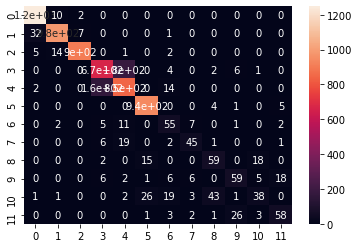

In [10]:
exp.train()

In [6]:
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [7]:
import numpy as np

In [8]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

torch.Size([2, 1, 128, 6])


In [9]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [10]:
out.shape

(2, 31, 128, 6)

In [20]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [18]:
for n,p in exp.model.named_parameters():
    print(n)

gamma
wave_conv.wavelet_conv.weight


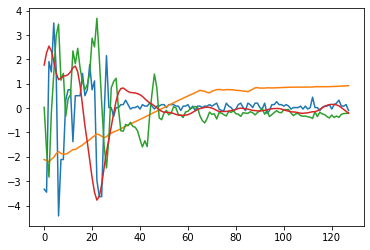

In [23]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [6]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)